In [26]:
import numpy as np #it's used for calculation
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd #to load up our data

data =pd.read_csv('iris.csv') # loading our data into the dataframe 'data'
data =data.drop(['Id'],axis=1)
data.head()


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


# Lets see how our data looks and does it contain any null value
** Data Cleaning and Visualization **
* We will use seaborn/matplotlib plots to visualize our data

** But why do we need visualization in the first place**
 * Data visualization is the presentation of data in a pictorial or graphical format. It enables us to see analytics presented      visually,we can grasp difficult concepts or identify new patterns.

In [27]:
data.isnull().sum() 

SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

It looks like we are good for our next step

Lets how many classification labels we have 


In [28]:
data['Species'].value_counts()

Iris-setosa        50
Iris-virginica     50
Iris-versicolor    50
Name: Species, dtype: int64

In [29]:
#split the data into data(numpy array) x and class labels y
X=data.ix[:,0:4].values
y=data.ix[:,4].values


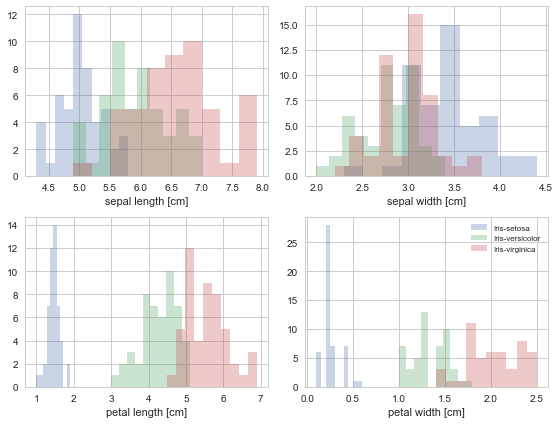

In [30]:
label_dict = {1: 'Iris-Setosa',
              2: 'Iris-Versicolor',
              3: 'Iris-Virgnica'}

feature_dict = {0: 'sepal length [cm]',
                1: 'sepal width [cm]',
                2: 'petal length [cm]',
                3: 'petal width [cm]'}

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 6))
    for cnt in range(4):
        plt.subplot(2, 2, cnt+1)
        for lab in ('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'):
            plt.hist(X[y==lab, cnt],
                     label=lab,
                     bins=10,
                     alpha=0.3,)
        plt.xlabel(feature_dict[cnt])
    plt.legend(loc='upper right', fancybox=True, fontsize=8)

    plt.tight_layout()


A we can see petal length and petal width are the best features to classify our labels

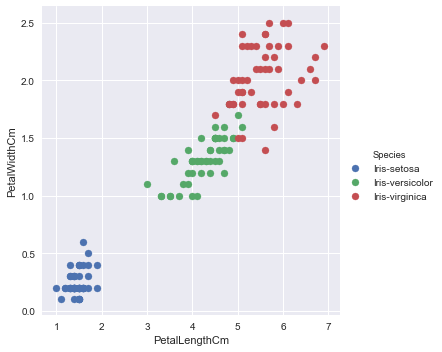

In [31]:
#let's visualize our data more by using seaborn plots
sns.FacetGrid(data ,hue='Species',size=5) \
.map(plt.scatter,"PetalLengthCm", "PetalWidthCm") \
.add_legend() 


Through this plot we can see how well we can distinguish our target label with these features

An another simple way of representing statistical data is with the help of Box plot.It is a convenient way of graphically depicting groups of numerical data through their quartiles(median)

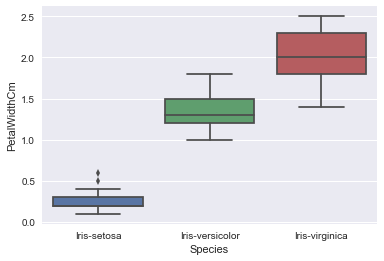

In [32]:

sns.boxplot(x='Species',y='PetalWidthCm',data=data)


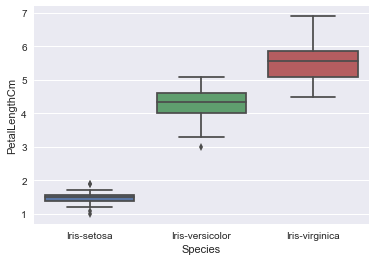

In [33]:
sns.boxplot(x='Species',y='PetalLengthCm',data=data)


C:\Users\Abhishek\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


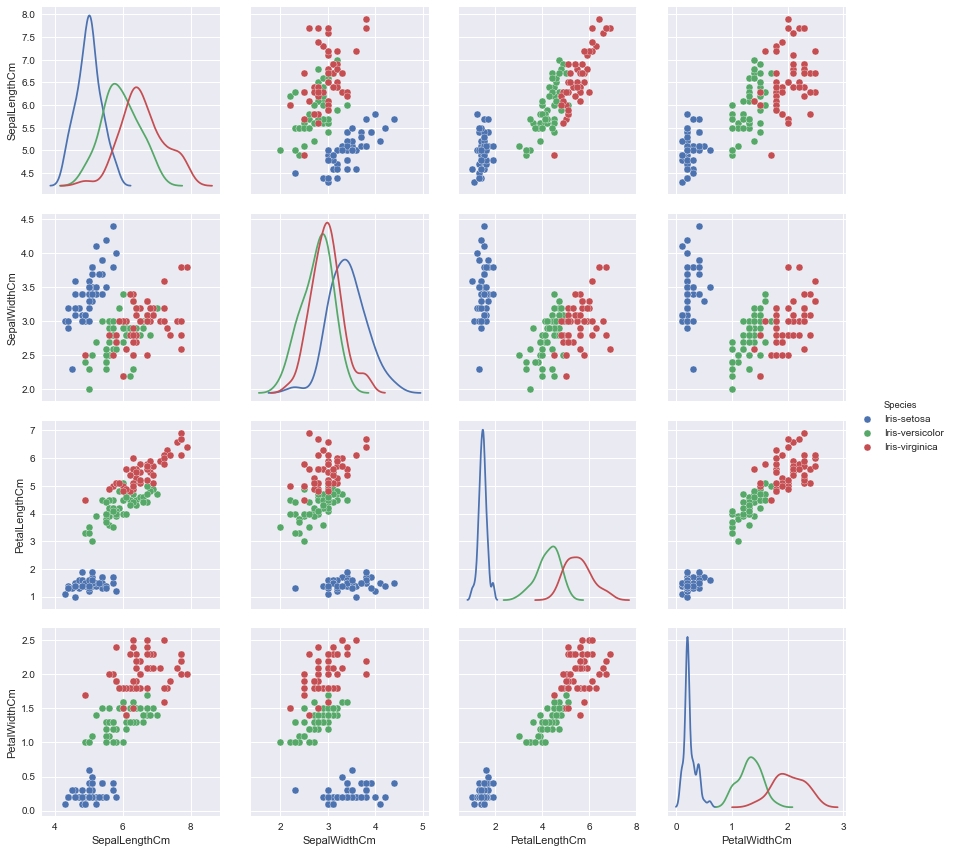

In [34]:
#in order to get the best bivariate relation between each pair of feature
sns.pairplot(data,hue ='Species',size =3,diag_kind ='kde')

#  Now Let's Check With the help of Feature Selection models to see how much information does our features contain

In [35]:
data['Species'] = data['Species'].map({'Iris-setosa':0,'Iris-versicolor':1,'Iris-virginica':2})

data.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [36]:
from sklearn.cross_validation import train_test_split #to shuffle and split our maid data into training and testing data
Y= data['Species'] #target variable
X =data.drop(['Species'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size =0.3,random_state =0)

In [37]:
# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold;

In [38]:
# Some useful parameters which will come in handy later on
ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

# Out-of-Fold Predictions 

Now as alluded to above in the introductory section, stacking uses predictions of base classifiers as input for training to a second-level model. However one cannot simply train the base models on the full training data, generate predictions on the full test set and then output these for the second-level training. This runs the risk of your base model predictions already having "seen" the test set and therefore overfitting when feeding these predictions.

In [39]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

# Generating our Base First-Level Models

So now let us prepare five learning models as our first level classification. These models can all be conveniently invoked via the Sklearn library and are listed as follows:
1. Random Forest classifier
2. Extra Trees classifier
3. AdaBoost classifer
4. Gradient Boosting classifer
5. Support Vector Machine

## Parameters
Just a quick summary of the parameters that we will be listing here for completeness,
* **n_jobs** : Number of cores used for the training process. If set to -1, all cores are used.
* **n_estimators** : Number of classification trees in your learning model ( set to 10 per default)
* **max_depth** : Maximum depth of tree, or how much a node should be expanded. Beware if set to too high a number would run the risk of overfitting as one would be growing the tree too deep
* **verbose** : Controls whether you want to output any text during the learning process. A value of 0 suppresses all text while a value of 3 outputs the tree learning process at every iteration.

Please check out the full description via the official Sklearn website. There you will find that there are a whole host of other useful parameters that you can play around with.

In [40]:
#Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [41]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

## Creating NumPy arrays out of our train and test sets
Great. Having prepared our first layer base models as such, we can now ready the training and test test data for input into our classifiers by generating NumPy arrays out of their original dataframes as follows:

In [42]:
y_trains = y_train.ravel()
x_trains =X_train.values
x_test = X_test.values

In [43]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_trains, y_trains, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_trains, y_trains, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_trains, y_trains, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_trains, y_trains, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_trains, y_trains, x_test) # Support Vector Classifier

print("Training is complete")

C:\Users\Abhishek\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:267: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Training is complete


### Feature importances generated from the different classifiers
Now having learned our the first-level classifiers, we can utilise a very nifty feature of the Sklearn models and that is to output the importances of the various features in the training and test sets with one very simple line of code.<br />
As per the Sklearn documentation, most of the classifiers are built in with an attribute which returns feature importances by simply typing in .featureimportances. Therefore we will invoke this very useful attribute via our function earliand plot the feature importances as such

In [44]:
rf_feature = rf.feature_importances(x_trains,y_trains)
et_feature = et.feature_importances(x_trains, y_trains)
ada_feature = ada.feature_importances(x_trains, y_trains)
gb_feature = gb.feature_importances(x_trains,y_trains)

C:\Users\Abhishek\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:267: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


[ 0.10114532  0.01196807  0.43257929  0.45430731]
[ 0.09317576  0.0432625   0.41836937  0.43319237]
[ 0.     0.     0.314  0.686]
[ 0.03049212  0.00565063  0.05513314  0.05539078]


In [46]:
rf_features = [ 0.10114532, 0.01196807, 0.43257929,  0.45430731]
et_features = [ 0.09317576,  0.0432625, 0.41836937,  0.43319237]
ada_features = [ 0.,     0.,     0.314,  0.686]
gb_features =[ 0.03049212,  0.00565063,  0.05513314,  0.05539078]

In [47]:
cols = X_train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [52]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(4)

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.000,0.093176,0.030492,0.101145,SepalLengthCm,0.056203
1,0.000,0.043263,0.005651,0.011968,SepalWidthCm,0.015220
2,0.314,0.418369,0.055133,0.432579,PetalLengthCm,0.305020
3,0.686,0.433192,0.055391,0.454307,PetalWidthCm,0.407223


In [53]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')